/var/folders/2_/jwb_y03d7jz9cvsz5dnz2_xw0000gn/T/ipykernel_4194/2648201916.py:114: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20', len(products_to_graph))


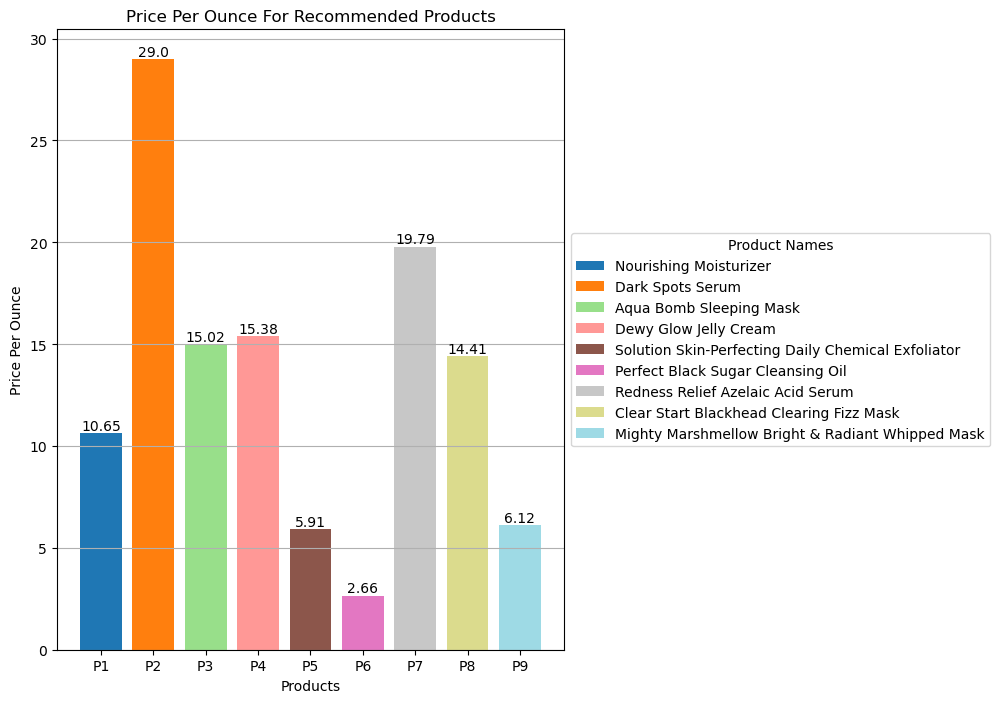

In [3]:
import tkinter as tk
from tkinter import simpledialog
from tkinter import font as tkFont
from tkinter import PhotoImage
import webbrowser
import pandas as pd
import sqlite3
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.cm as cm


def open_link(url):
    webbrowser.open_new(url)

#Function that converts data from excel file into a database and turns the data from database into a dictionary
def get_database_dictionary(which_dict):
    data_path = 'data.xlsx' 
    df = pd.read_excel(data_path) #reads the data and converts from excel file into a dataframe df
    
    #defines file path for SQLite database and creates connection to database
    db_path = 'database.db'
    conn = sqlite3.connect(db_path)
    df.to_sql('data_table', conn, index=True, if_exists='replace')
    cursor = conn.cursor() #sets up cursor to fetch variables later
    product_table = 'data_table'
    quest = f'SELECT * FROM {product_table};' #sets up a quest to all the data from the data table named product_table
    cursor.execute(quest) #uses the cursor tool to execute quest, so the cursor holds the data
    rows = cursor.fetchall()#gets all the data and creates a list of tuples (which contain product information)
    conn.close()
    by_number_dict = {}
    by_name_dict = {}
    
    #iterates through each product
    for i in range(len(rows)):
        user_list = list(rows[i]) #creates a temporary list from the tuple for each specific product
        by_number_dict[f"{i}"]  = rows[i] #uses product location as key
        by_name_dict[f"{user_list[3]}"]  = rows[i] #uses product name as key
        
    if which_dict == "number":
        final_dict = by_number_dict
    if which_dict == "name":
        final_dict = by_name_dict
        
    return final_dict

def recommend_products(user_responses):
    database_dict = get_database_dictionary("number") #calls prior function, returns a dictionary with all the products' data
    lowercase = [x.lower() for x in user_responses]
    skin_type, skin_concern, product_type = lowercase[0], lowercase[1], lowercase[2]
    all_three = []
    just_two = []
    just_one = []
    

    #iterates through each product in the database dictionary
    for i in range(len(database_dict)):
        count = 0
        attributes = database_dict[f"{i}"]
        
        #these if statements count up the number of matching attributes with user responses for each product
        if skin_type in attributes[9] or "all" in attributes[9]:
            count += 1 #if the skin type of the user matches the skin types the product is intended for, adds one
        if skin_concern in attributes[13]:
            count += 1 #if the skin concerns the product adresses match the user's skin concern, adds one
        if product_type in attributes[2]:
            count += 1 #if the product type matches what the user requested, adds one
            
        if count == 1: #appends to a list of products that match 1/3 of the user's inputs
            just_one.append((attributes[3], attributes[4])) #includes product type and brand in a tuple
        elif count == 2: #appends to a list of products that match 2/3 of the user's inputs
            just_two.append((attributes[3], attributes[4]))
        elif count == 3: #appends to a list of products that match 3/3 of the user's inputs
            all_three.append((attributes[3], attributes[4]))
   
    
    whole_list = [just_one, just_two, all_three]
    for i in range(len(whole_list)):
        if len(whole_list[i]) > 3: #only want up to three products in each category
            whole_list[i] = random.sample(whole_list[i], 3) #randomly selects three products and appends the list

    return whole_list


#takes the output of recommend_products and returns a list of tuples of (product name, price/oz)
def product_price(user_responses):
    database_dict = get_database_dictionary("name") #this time, the key for the database is product name
    products_to_price = recommend_products(user_responses) #calls for prior function using user inputs
    just_the_name, one_two_or_threes_from_reccomend, priced_list = [], [], []
   
    #iterates through the 3 lists of category 1, 2, and 3 products from recommend_products
    for i in range(len(products_to_price)):
        one_two_or_threes_from_reccomend = products_to_price[i] #seperates just the category 1, 2, or 3 products
        for i in range(len(one_two_or_threes_from_reccomend)): #iterates through the products in each category
            individual = one_two_or_threes_from_reccomend[i] #defines the product currently being iterated through
            individual_product_info = database_dict[f"{individual[0]}"] #uses that product's name to call the definition for that specific product, retrieving all the product info
            price_per_oz = individual_product_info[15]/individual_product_info[5] #divides total price by ounces of product
            priced_list.append((individual_product_info[3], price_per_oz)) #returns product name and price per oz of each product in a tuple
    
    return priced_list

def price_graph(recommended_products, parent_window, user_responses):
    plt.close('all')
    products_to_graph = product_price(user_responses)
    product_names, prices = zip(*products_to_graph) #unzips products_to_graph (product name, price) into two tuples (product name) and (graph)
    product_labels = [f'P{i + 1}' for i in range(len(product_names))] #creates labels for x-axis of bar graph

    # creates a new figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # generate colors using a colormap
    color_map = cm.get_cmap('tab20', len(products_to_graph))
    colors = color_map(range(len(products_to_graph)))

    # create a bar graph
    bars = ax.bar(product_labels, prices, color=colors) 

    # adds the text on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

    # adds labels and title
    plt.xlabel('Products')
    plt.ylabel('Price Per Ounce')
    plt.title('Price Per Ounce For Recommended Products')

    # creates a legend with each of the product names and the colors 
    plt.legend(bars, product_names, title='Product Names', loc='center left', bbox_to_anchor=(1, 0.5))

    # adds grid lines 
    plt.grid(axis='y')

    # adjusts layout of the legend
    plt.tight_layout(rect=[0, 0, 0.8, 1])

    # embeds the graph into the parent_window Tkinter 
    canvas = FigureCanvasTkAgg(fig, master=parent_window)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    

def show_question(question, options, next_function):
    question_window = tk.Toplevel(root, bg='white')
    question_window.title("Question")
   
    # sets the font to match the opening page and text color to black
    question_label = tk.Label(question_window, text=question, bg='white', fg='black', font=description_font, justify='center')
    question_label.pack(padx=10, pady=10) 

    answer = tk.StringVar(question_window)
    answer.set(options[0])  

    # sets the font for the options menu
    option_menu = tk.OptionMenu(question_window, answer, *options)
    option_menu.config(highlightthickness=0, bg='white', fg='black', font=button_font)
    option_menu.pack(padx=10, pady=10) 
   
    # style the next button to match the opening page
    next_button = tk.Button(question_window, text="Next", command=lambda: handle_answer(question_window, answer, next_function))
    next_button.config(highlightthickness=0, font=button_font, bg='white', fg='green')
    next_button.pack(padx=10, pady=20)

#a function to handle user responses in the GUI
def handle_answer(window, answer, next_function):
    responses.append(answer.get())
    window.destroy()
    next_function()

# a function to show skincare recommendations and options
def show_recommendations():
    # the first question to the user about their skin type,
    show_question(questions[0], skin_type_options,
                  #show the second question about skin concerns
                                        lambda: show_question(questions[1], skin_concern_options,
                                                              #show the third question about product type and display recommendations
                                                              lambda: show_question(questions[2], product_type_options, display_recommendations)))

def display_recommendations():
    recommended_products = recommend_products(responses)  # store the recommended products

    recommendations_window = tk.Toplevel(root, bg='white')
    recommendations_window.title("Your Recommendations")

    # function to display products
    def display_products(products, title):
        section_title = tk.Label(recommendations_window, text=title, fg="black", bg='white', font=subtitle_font)
        section_title.pack()

        for product_type, brand in products:
            product_info = f"{product_type} - {brand}"
            label = tk.Label(recommendations_window, text=product_info, fg="black", cursor="hand2", bg='white')
            label.pack()

    # display each set of products
    if recommended_products[0]:
        display_products(recommended_products[0], "Category 1 Recommendations")
    if recommended_products[1]:
        display_products(recommended_products[1], "Category 2 Recommendations")
    if recommended_products[2]:
        display_products(recommended_products[2], "Category 3 Recommendations")

    # call the price_graph function with the already obtained recommended_products
    # the graph will be displayed inside the recommendations_window
    price_graph(recommended_products, recommendations_window, responses)
       
root = tk.Tk()
root.title("DermaDive Skin Quiz")

# set the window size and position
window_width = 1000
window_height = 700
root.geometry(f"{window_width}x{window_height}")

# set a background color
root.configure(bg='white')

# customize fonts
title_font = tkFont.Font(family="Quicksand", size=30, weight="bold")
subtitle_font = tkFont.Font(family="Quicksand", size=25)
description_font = tkFont.Font(family="Quicksand", size=20, weight = "bold")
description_font_2 = tkFont.Font(family = "Quicksand", size = 17)
button_font = tkFont.Font(family="Quicksand", size=15)

# create a frame to center
center_frame = tk.Frame(root, bg='white')
center_frame.pack(expand=True)

# title
title_label = tk.Label(center_frame, text="DermaDive", font=title_font, bg='white', fg='black')
title_label.pack()  # the title is centered horizontally

# subtitle
subtitle_label = tk.Label(center_frame, text="Skin Quiz", font=subtitle_font, bg='white', fg='black')
subtitle_label.pack()  # the subtitle is centered horizontally 

# description - use wraplength to fit the text in the window
description_label = tk.Label(center_frame, text="Welcome to DermaDive!",
                             font=description_font, bg='white', fg='black', justify='center', wraplength=window_width - 100)  # Adjust wraplength as needed
description_label.pack(pady=(20, 20))

description_label_2 = tk.Label(center_frame, text="Dermadive's Skin Quiz is your gateway to bespoke skincare, offering tailored solutions that dive deep into your skin's unique needs for a glowing, healthy complexion.\n \n At the end you will receive up to 3 categories. Category 1 are products with just one of your preferences, Category 2 are products with two of your preferences, and Category 3 are products with all three of your preferences (which may or may not exist).",
                             font=description_font_2, bg='white', fg='black', justify='center', wraplength=window_width - 100)
description_label_2.pack()
# start button
start_button = tk.Button(center_frame, text="Take the Quiz", command=show_recommendations, font=button_font, bg='white', fg='green', bd=0, highlightthickness=0)
start_button.pack(pady=(10, 20))

# array of questions that will be outputted
questions = [
    "What is your primary skin type?",
    "What is your primary skin concern?",
    "What type of product are you looking for?",
]

# the array of the answer options
skin_type_options = ["Select an option", "Normal", "Oily", "Dry", "Combination"]
skin_concern_options = ["Select an option", "Acne", "Wrinkles", "Dryness", "Dullness"]
product_type_options = ["Select an option", "Toner", "Spot Treatment", "Moisturizer", "Suncreen", "Cleanser", "Oil", "Serum", "Exfoliant"]

#responses that the user outputs will be stored here
responses = []

root.mainloop()